# Braille Project

In this project we attempt to build a classifier for [Braille dataset](https://www.kaggle.com/datasets/shanks0465/braille-character-dataset?resource=download). The dataset contains 1560 images of Braille aplhabet for English language. For each alphabet letter there are 60 images: with different rotation, contrast and other augmentation techniques applied.


## Preparation


### Import

In [1]:
# !pip install torchvision

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import matplotlib.pyplot as plt
import copy
import os
import fnmatch
from skimage import io
import shutil
import random
from tqdm import tqdm
from IPython.display import display, Image
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
import math

In [36]:
# Uncomment when working with Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

In [37]:
# Path to the folder containing the project
root = ""

It is expected that Braille Dataset is already extracted and stored in the root folder.

In [38]:
image_dir = f"{root}Braille Dataset/" # The dataset folder containging images (please note that )

# New folders to create for data pre-processing
data_dir = f"{root}Data/" #The new folder
viz_dir = f"{root}Graphs/" #To store the differents graphics

In [39]:
# Create new folders
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
if not os.path.exists(viz_dir):
    os.makedirs(viz_dir)

# Reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

### Data preparation

First we need a new files organisation to be able to use the Torchvision DataLoader :

In [40]:
# Find all classes (= letters of alphabet) by extracting it from the filename
classes = []
for root, dirnames, filenames in os.walk(image_dir):
    for filename in fnmatch.filter(filenames, '*.jpg'):
        classes.append(os.path.join(root, filename).replace(image_dir, '')[0])
classes = set(classes)
num_classes = len(classes)

# Create a new folder for each classes
for c in classes:
    if not os.path.exists(data_dir+c):
        os.makedirs(data_dir+c)

# Copy all files to the right folder
for root, dirnames, filenames in os.walk(image_dir):
    for filename in fnmatch.filter(filenames, '*.jpg'):
        classe = os.path.join(root, filename).replace(image_dir, '')[0]
        shutil.copyfile(image_dir+filename, data_dir+classe+"/"+filename)

In [41]:
# Create DataLoader
dataset = datasets.ImageFolder(data_dir, transforms.Compose([transforms.ToTensor()]))
dataset

Dataset ImageFolder
    Number of datapoints: 1560
    Root location: Data/
    StandardTransform
Transform: Compose(
               ToTensor()
           )

The ImageFolder alloww us to automatically generate the dataset if the images are organised in folders for each class.

In [17]:
dataset.__getitem__(0)[0]

tensor([[[0.7608, 0.8000, 0.8078,  ..., 0.7686, 0.7686, 0.7686],
         [0.7569, 0.6941, 0.7373,  ..., 0.7686, 0.7686, 0.7686],
         [0.7804, 0.7961, 0.7647,  ..., 0.7686, 0.7686, 0.7686],
         ...,
         [0.7686, 0.7725, 0.7647,  ..., 0.7686, 0.7686, 0.7686],
         [0.7725, 0.7765, 0.7765,  ..., 0.7686, 0.7686, 0.7686],
         [0.7608, 0.7686, 0.7725,  ..., 0.7686, 0.7686, 0.7686]],

        [[0.7608, 0.8000, 0.8078,  ..., 0.7686, 0.7686, 0.7686],
         [0.7569, 0.6941, 0.7373,  ..., 0.7686, 0.7686, 0.7686],
         [0.7804, 0.7961, 0.7647,  ..., 0.7686, 0.7686, 0.7686],
         ...,
         [0.7686, 0.7725, 0.7647,  ..., 0.7686, 0.7686, 0.7686],
         [0.7725, 0.7765, 0.7765,  ..., 0.7686, 0.7686, 0.7686],
         [0.7608, 0.7686, 0.7725,  ..., 0.7686, 0.7686, 0.7686]],

        [[0.7608, 0.8000, 0.8078,  ..., 0.7686, 0.7686, 0.7686],
         [0.7569, 0.6941, 0.7373,  ..., 0.7686, 0.7686, 0.7686],
         [0.7804, 0.7961, 0.7647,  ..., 0.7686, 0.7686, 0.

In [18]:
dataset.__getitem__(0)[0].shape

torch.Size([3, 28, 28])

With ImageFolder, the label are replaced with an indice so we need a dictionnary to get back the labels.

In [19]:
alphabet = dict((v, k) for k, v in dataset.class_to_idx.items())
alphabet

{0: 'a',
 1: 'b',
 2: 'c',
 3: 'd',
 4: 'e',
 5: 'f',
 6: 'g',
 7: 'h',
 8: 'i',
 9: 'j',
 10: 'k',
 11: 'l',
 12: 'm',
 13: 'n',
 14: 'o',
 15: 'p',
 16: 'q',
 17: 'r',
 18: 's',
 19: 't',
 20: 'u',
 21: 'v',
 22: 'w',
 23: 'x',
 24: 'y',
 25: 'z'}

Finally, we split the dataset between the train and test set

In [20]:
# Train-test split and batch split
batch_size = 8

data_size = len(dataset)

# 80% of the data is set to be training, 10% validation and 10% test
train_size = int(0.8*data_size)
test_size = int(0.1*data_size)
valid_size = data_size - train_size - test_size

# Split the data randomly
train_data, test_data, valid_data = random_split(dataset, [train_size, test_size, valid_size])

# Create DataLoader for each split
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)

### Data Visualisation (1)

To check the previous steps, we visualize a example batch :

In [21]:
def show_batch(image_batch, classes_batch):
    # The labels are numbers instead of classes
    plt.figure(figsize = (10,6))
    for ib in range(5):
        plt.subplot(1, 5, ib+1)
        plt.imshow(image_batch[ib, :].squeeze().detach().permute(1, 2, 0), cmap='gray_r')
        plt.xticks([]), plt.yticks([])
        plt.title('Image label = ' + alphabet[classes_batch[ib].item()])
    plt.show()

torch.Size([8, 3, 28, 28]) torch.Size([8])


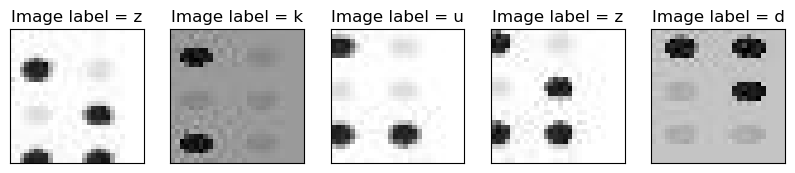

In [22]:
image_batch_example, classes_batch_example = next(iter(train_dataloader))
print(image_batch_example.shape, classes_batch_example.shape)

show_batch(image_batch_example, classes_batch_example)

We can see that for example for letter "w" the rotation of almost 90 degrees is applied and additionally other images have a colored filter applied on top.


### CNN Playground

We start by testing the different steps of a 2 layers CNN manually in order to better understand what we are going to do.

In [23]:
# Target number of classes = each letter of the alphabet
num_classes = len(alphabet)

In [24]:
cnn_layer1 = nn.Sequential(nn.Conv2d(3, 16, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.MaxPool2d(kernel_size=2))
out1 = cnn_layer1(image_batch_example)
print(out1.shape)

torch.Size([8, 16, 14, 14])


In [25]:
cnn_layer2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.MaxPool2d(kernel_size=2))
out2 = cnn_layer2(out1)
print(out2.shape)

torch.Size([8, 32, 7, 7])


In [26]:
out_vec = out2.reshape(out2.shape[0], -1)
print(out_vec.shape)

cnn_layer3 = nn.Linear(1568, num_classes)
outout = cnn_layer3(out_vec)
print(outout.shape)

torch.Size([8, 1568])
torch.Size([8, 26])


### Module Cnn Classifier and functions

Then we create a CNNClassif module. The idea is to put the most possible things in the arguments including the number of convolution layers in order to later determinate the best architecture.

In [27]:
class CNNClassif(nn.Module):
    """Create a Classifier Module.
    input_size_linear - int, size of the matrix after all convolutions, flattened.
    num_layers - int, number of convolution layers.
    num_channels - array of ints, expected to be of size num_layers + 1. Contains the list of feature map (channel) sizes, including the initial one.
    num_classes - int, number of classes to predict.
    conv_kernel - int, kernel size of convolution layer. The same kernel size is used for all convolution layers.
    padding - int, padding for convolution. The same padding is used for all convolution layers.
    act_fn - PyTorch Function, activation function of a convolution layer. The same function is used in all layers.
    norm - bool, whether or not normalization is applied in convolution layers. Applied for all convolution layers.
    pooling - PyTorch pooling. Applied in all convolution layers.
    """
    def __init__(self, input_size_linear, num_layers, num_channels, num_classes,
                 conv_kernel=5, padding=2, act_fn=nn.ReLU(), norm=False,
                 pooling=nn.MaxPool2d(kernel_size=2)):
        super(CNNClassif, self).__init__()
        layers = []
        # If norm is passed, use Batch normalization
        if norm:
            for i in range(num_layers):

                num_channels1 = num_channels[i]
                num_channels2 = num_channels[i+1]
                seq = nn.Sequential(nn.Conv2d(num_channels1,
                                              num_channels2,
                                              kernel_size=conv_kernel,
                                              padding=padding),
                            act_fn,
                            nn.BatchNorm2d(num_channels2),
                            pooling)
                layers.append(seq)
        else:
            for i in range(num_layers):
                num_channels1 = num_channels[i]
                num_channels2 = num_channels[i+1]
                seq = nn.Sequential(nn.Conv2d(num_channels1,
                                              num_channels2,
                                              kernel_size=conv_kernel,
                                              padding=padding),
                            act_fn,
                            pooling)
                layers.append(seq)

        # Join all convolution layers together
        self.conv_layers = nn.Sequential(*layers)

        self.lin_layer = nn.Linear(input_size_linear, num_classes)


    def forward(self,x):
        # Apply all layers of convolution
        conv_out = self.conv_layers(x)
        # Flatten the output
        out_vec = conv_out.reshape(conv_out.shape[0], -1)
        # Pass to the linear layer for the classification
        return self.lin_layer(out_vec)

In [28]:
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight.data)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    return

We then create an evaluation function.

In [29]:
def eval_cnn_classifier(model, eval_dataloader, loss_fn):

    # Initialisation
    model.eval()
    val_loss = 0

    # Loop over batches
    with torch.no_grad():
        for images, labels in eval_dataloader:
            y_predicted = model(images)
            loss = loss_fn(y_predicted, labels)
            val_loss += loss.item()

    return val_loss / len(eval_dataloader)

Finally we create the training loop.

In [30]:
def training_cnn_classifier(model_tr, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate, verbose=False):

    # Initialisation
    optimizer = torch.optim.SGD(model_tr.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []
    val_loss_opt = math.inf
    model_tr.train()
    # Training
    for epoch in range(num_epochs):

        tr_loss = 0
        # Loop over batches
        for images, labels in train_dataloader:
            pred_labels = model_tr(images)
            loss = loss_fn(pred_labels, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            tr_loss+=loss.item()

        # Losses
        tr_loss = tr_loss/len(train_dataloader.dataset)
        train_losses.append(tr_loss)
        val_loss = eval_cnn_classifier(model_tr, valid_dataloader, loss_fn)
        val_losses.append(val_loss)

        if val_loss < val_loss_opt:
            # If an observed validation loss is smaller than previously observed minimum, update the optimal model
            model_opt = copy.deepcopy(model_tr)
            val_loss_opt = val_loss

        # Display the training loss and validation accuracy
        if verbose:
            print('Epoch [{}/{}], Training loss: {:.4f} ; Validation loss: {:.4f}'
                  .format(epoch+1, num_epochs, tr_loss, val_loss))

    # Implement early stopping and return optimal model only
    return model_opt, train_losses, val_losses

### Experiment function

In order to better test the differents parameters and hyper-parameters, an experiment function was created wich instentiate a model, train it and show and save the loss over epochs graph.

In [31]:
def experiment(input_size_linear, num_layers, num_channels, num_epochs, loss_fn,
               learning_rate, name, show=True, norm=False,
                conv_kernel=5, padding=2, act_fn=nn.ReLU(),
                 pooling=nn.MaxPool2d(kernel_size=2), verbose=False):
    # Instantiation
    num_classes = len(alphabet)
    model = CNNClassif(input_size_linear, num_layers, num_channels, num_classes,
                        conv_kernel=conv_kernel, padding=padding,
                       act_fn=act_fn, norm=norm,
                 pooling=pooling)

    # Training
    model_opt, train_losses, eval_losses = training_cnn_classifier(model, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate, verbose)

    # Plot the loss
    plt.plot(train_losses, label='Training')
    plt.plot(eval_losses, label='Validation')
    plt.xlabel('Epochs'), plt.ylabel('Loss')
    plt.legend()
    plt.title(name)
    plt.savefig(viz_dir + name +'.png')
    if show:
        plt.show()
    else:
        plt.close()

    return model_opt, train_losses, eval_losses


### Test of the functions

We can try the functions and train a dummy model to see how it performs.

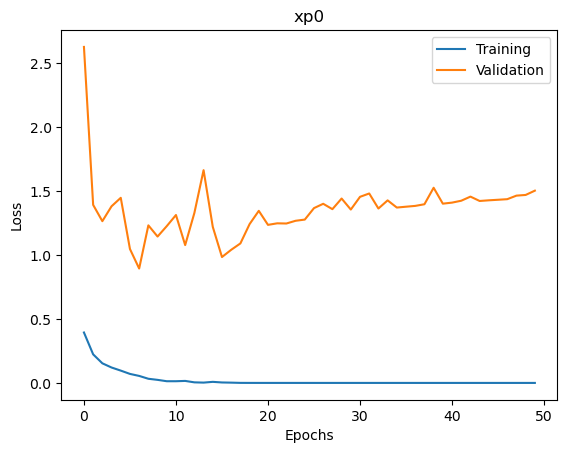

Train loss: 0.000014
Test loss: 1.502503


In [32]:
# Parameters
num_layers = 2
num_channels = [3, 16, 32]
input_size_linear = 1568
num_epochs = 50
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.1

# Experiment
model_opt, train_loss, eval_loss = experiment(input_size_linear, num_layers, num_channels, num_epochs, loss_fn, learning_rate, "xp0")

torch.save(model_opt.state_dict(), "dummy.pt")

print('Train loss: {:.6f}\nTest loss: {:.6f}'.format(train_loss[-1], eval_loss[-1]))


### Data Visualisation (2)

We can now visualize the predictions of the dummy model:

In [33]:
def show_pred_batch(image_batch, classes_batch, model):
    y_predicted = model(image_batch)
    _, label_predicted = torch.max(y_predicted.data, 1)

    plt.figure(figsize = (10,6))
    for ib in range(5):
        plt.subplot(1, 5, ib+1)
        plt.imshow(image_batch[ib, :].squeeze().detach().permute(1, 2, 0), cmap='gray_r')
        plt.xticks([]), plt.yticks([])
        plt.title('Image label = ' + alphabet[classes_batch[ib].item()] + '\nPredicted = ' + alphabet[label_predicted[ib].item()])
    plt.show()

/var/folders/z9/h7ylrst12z96gvslx_2n2p7c0000gp/T/ipykernel_56050/3230636488.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('dummy.pt'))

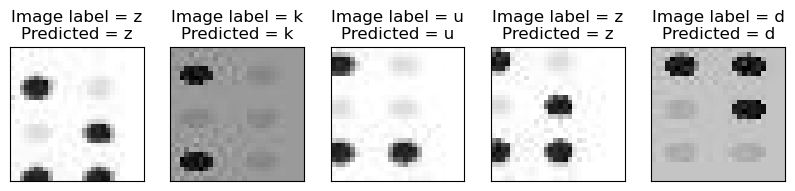

In [34]:
num_channels = [3, 16, 32]
num_classes = len(classes)
input_size_linear = 1568

model = CNNClassif(input_size_linear, 2, num_channels, num_classes)
model.load_state_dict(torch.load('dummy.pt'))
show_pred_batch(image_batch_example, classes_batch_example, model)

As we can see from the example, even with dummy setup the model predicts the correct label quite well.

## Experiments

### Experiment 1 : Batch Normalisation

In the first experiment we want to asses whether of not it is worth using batch normalization for the task, since the applied permutations can vastly affect the performance with normalization

In [35]:
num_layers = 2
num_channels = [3, 16, 32]
input_size_linear = 1568
num_epochs = 20
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.005

In [ ]:
# Create a model without normalization
model_nonorm_opt, train_losses, val_losses = experiment(input_size_linear,
                                                                num_layers=num_layers,
                                                               num_channels=num_channels,
                                                                num_epochs=num_epochs,
                                                                loss_fn=loss_fn,
                                                                learning_rate=learning_rate,
                                                                name="xp1_no_norm",
                                                                show=False,
                                                                norm=False,
                                                                verbose=True)

Epoch [1/20], Training loss: 0.4076 ; Validation loss: 3.2609
Epoch [2/20], Training loss: 0.4067 ; Validation loss: 3.2590
Epoch [3/20], Training loss: 0.4061 ; Validation loss: 3.2525
Epoch [4/20], Training loss: 0.4052 ; Validation loss: 3.2472
Epoch [5/20], Training loss: 0.4037 ; Validation loss: 3.2339
Epoch [6/20], Training loss: 0.4007 ; Validation loss: 3.2024
Epoch [7/20], Training loss: 0.3928 ; Validation loss: 3.1136
Epoch [8/20], Training loss: 0.3702 ; Validation loss: 2.8386
Epoch [9/20], Training loss: 0.3032 ; Validation loss: 2.1350
Epoch [10/20], Training loss: 0.2194 ; Validation loss: 1.6422
Epoch [11/20], Training loss: 0.1798 ; Validation loss: 1.5358
Epoch [12/20], Training loss: 0.1608 ; Validation loss: 1.4931
Epoch [13/20], Training loss: 0.1462 ; Validation loss: 1.5651
Epoch [14/20], Training loss: 0.1362 ; Validation loss: 1.3341
Epoch [15/20], Training loss: 0.1260 ; Validation loss: 1.3397
Epoch [16/20], Training loss: 0.1186 ; Validation loss: 1.2994
E

In [ ]:
# Create a model with normalization
model_norm_opt, train_losses_norm, val_losses_norm = experiment(input_size_linear,
                                                                num_layers=num_layers,
                                                               num_channels=num_channels,
                                                                num_epochs=num_epochs,
                                                                loss_fn=loss_fn,
                                                                learning_rate=learning_rate,
                                                                name="xp1_norm",
                                                                show=False,
                                                                norm=True,
                                                                verbose=True)

Epoch [1/20], Training loss: 0.2729 ; Validation loss: 1.7500
Epoch [2/20], Training loss: 0.1805 ; Validation loss: 1.5300
Epoch [3/20], Training loss: 0.1151 ; Validation loss: 1.2913
Epoch [4/20], Training loss: 0.0785 ; Validation loss: 1.2306
Epoch [5/20], Training loss: 0.0529 ; Validation loss: 1.1945
Epoch [6/20], Training loss: 0.0367 ; Validation loss: 1.1289
Epoch [7/20], Training loss: 0.0204 ; Validation loss: 0.9992
Epoch [8/20], Training loss: 0.0175 ; Validation loss: 1.2470
Epoch [9/20], Training loss: 0.0088 ; Validation loss: 1.2207
Epoch [10/20], Training loss: 0.0043 ; Validation loss: 1.1626
Epoch [11/20], Training loss: 0.0096 ; Validation loss: 1.1208
Epoch [12/20], Training loss: 0.0064 ; Validation loss: 1.2754
Epoch [13/20], Training loss: 0.0028 ; Validation loss: 1.1680
Epoch [14/20], Training loss: 0.0010 ; Validation loss: 1.1813
Epoch [15/20], Training loss: 0.0005 ; Validation loss: 1.2648
Epoch [16/20], Training loss: 0.0004 ; Validation loss: 1.2595
E

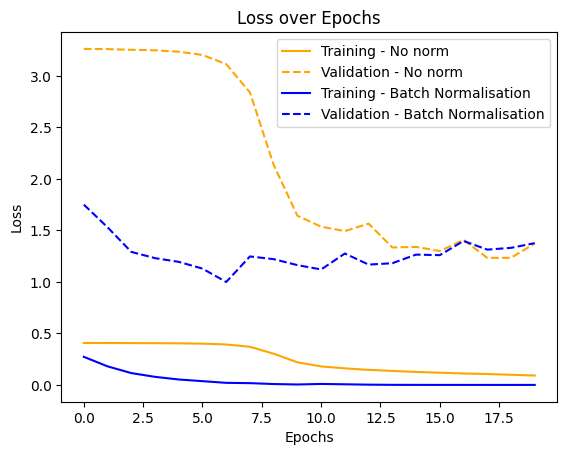

In [ ]:
# Plot Training and Validationlosses for both models
p1 = plt.plot(train_losses, label='Training - No norm', c='orange')
p2 = plt.plot(val_losses, label='Validation - No norm', c='orange', ls='dashed')
p3 = plt.plot(train_losses_norm, label='Training - Batch Normalisation', c='blue')
p4 = plt.plot(val_losses_norm, label='Validation - Batch Normalisation', c='blue', ls='dashed')
plt.legend()

plt.xlabel('Epochs'), plt.ylabel('Loss')
plt.title("Loss over Epochs")
plt.savefig(viz_dir + 'xp1.png')


In [ ]:
# Calculate accuracy on test for a given model
def get_ypred_ytrue(m):
  y_pred = []
  y_true = []

  for images, labels in test_dataloader:
    pred_labels = m(images)
    pred = [int(x.argmax()) for x in pred_labels]
    y_pred.extend(pred)
    y_true.extend([int(x) for x in labels])

  return y_pred, y_true

In [ ]:
y_pred_nonorm, y_true_nonorm = get_ypred_ytrue(model_nonorm_opt)
print(f"Accuracy, no norm: {accuracy_score(y_pred=y_pred_nonorm, y_true=y_true_nonorm)}")

y_pred_norm, y_true_norm = get_ypred_ytrue(model_norm_opt)
print(f"Accuracy, batch norm: {accuracy_score(y_pred=y_pred_norm, y_true=y_true_norm)}")

Accuracy, no norm: 0.7051282051282052
Accuracy, batch norm: 0.8397435897435898


We can see that batch normalization manages to achieve a significantly higher accuracy. Since we want to produce robust representations of images, working well with all permutations.

### Experiment 2 : Numbers of layers

In [ ]:
def experiment2(num_layers, input_size_linear, num_channels, learning_rate):
    num_epochs = 30
    loss_fn = nn.CrossEntropyLoss()

    train_losses = []
    eval_losses = []

    min_lr = 0
    min_train = 0
    min_eval = math.inf
    min_train_losses = []
    min_eval_losses = []

    # Experiment
    for lr in tqdm(learning_rate):
        model, train_loss, eval_loss = experiment(input_size_linear, num_layers, num_channels, num_epochs, loss_fn, lr, "xp1-"+str(num_layers)+"layers-lr"+str(lr), show=False, norm=True)
        train_losses.append(train_loss[-1])
        eval_losses.append(eval_loss[-1])
        if min_eval > eval_loss[-1]:
            min_lr = lr
            min_train = train_loss[-1]
            min_eval = eval_loss[-1]
            min_train_losses = train_losses
            min_eval_losses = eval_losses

    plt.plot(learning_rate, train_losses, label='Training')
    plt.plot(learning_rate, eval_losses, label='Validation')
    plt.xlabel('Learning Rate'), plt.ylabel('Loss')
    plt.xticks(learning_rate)
    plt.legend()
    plt.title("Loss over Learning Rate for "+str(num_layers)+" layers")
    plt.savefig(viz_dir + 'xp1'+str(num_layers)+'.png')
    plt.show()

    return model, min_lr, min_train, min_eval, min_train_losses, min_eval_losses


#### 2 layers model

100%|██████████| 16/16 [08:18<00:00, 31.13s/it]


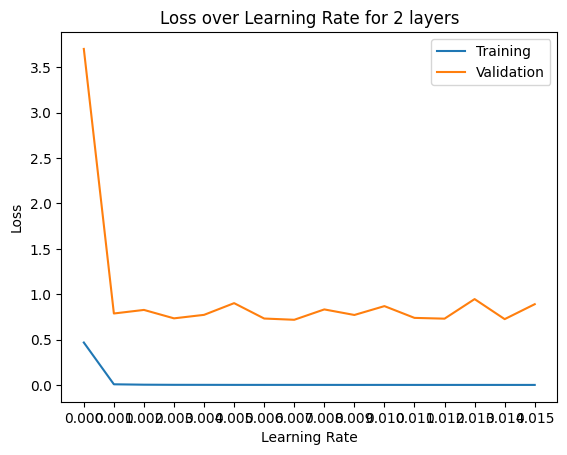

In [ ]:
# Parameters
num_layers = 2
input_size_linear = 1568
num_channels = [3, 16, 32]
learning_rate = [x/10000 for x in range(0, 151, 10)]

model_2l_opt, min_lr2, min_train_2l, min_test_2l, train_loss_2l, val_loss_2l = experiment2(num_layers, input_size_linear, num_channels, learning_rate)

#### 3 layers model

100%|██████████| 16/16 [10:21<00:00, 38.84s/it]


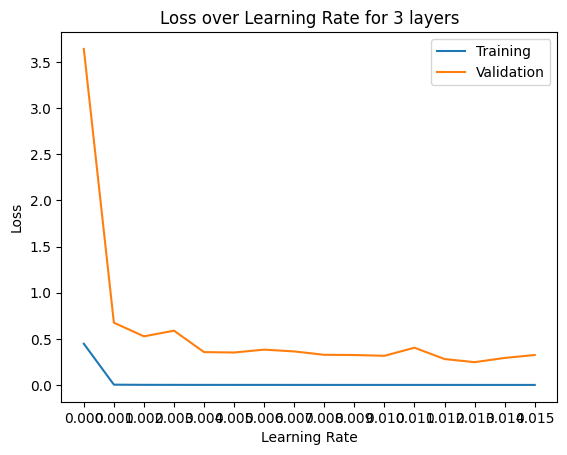

In [ ]:
# Parameters
num_layers = 3
input_size_linear = 576
num_channels = [3, 16, 32, 64]
learning_rate = [x/10000 for x in range(0, 151, 10)]

model_3l_opt, min_lr3, min_train_3l, min_test_3l, train_loss_3l, val_loss_3l = experiment2(num_layers, input_size_linear, num_channels, learning_rate)

#### 4 layers model

100%|██████████| 16/16 [12:24<00:00, 46.53s/it]


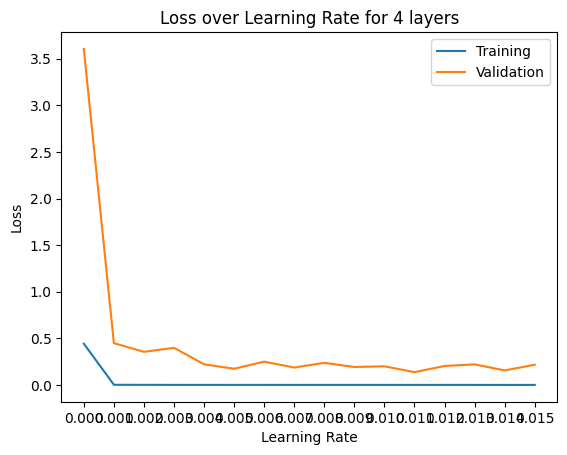

In [ ]:
# Parameters
num_layers = 4
input_size_linear = 128
num_channels = [3, 16, 32, 64, 128]
learning_rate = [x/10000 for x in range(0, 151, 10)]

model_4l_opt, min_lr4, min_train_4l, min_test_4l, train_loss_4l, val_loss_4l = experiment2(num_layers, input_size_linear, num_channels, learning_rate)


#### Comparaison

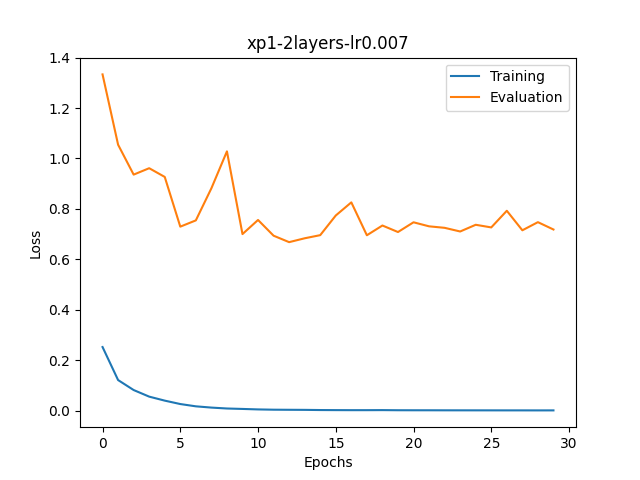

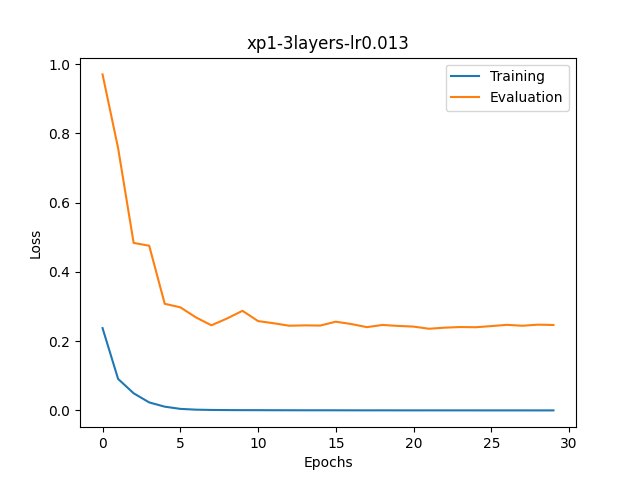

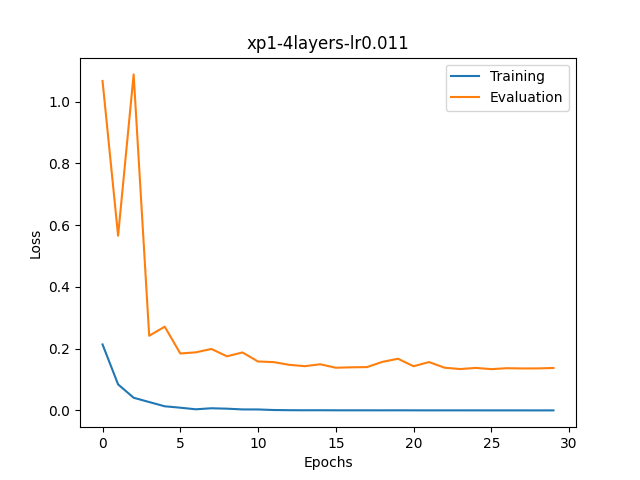

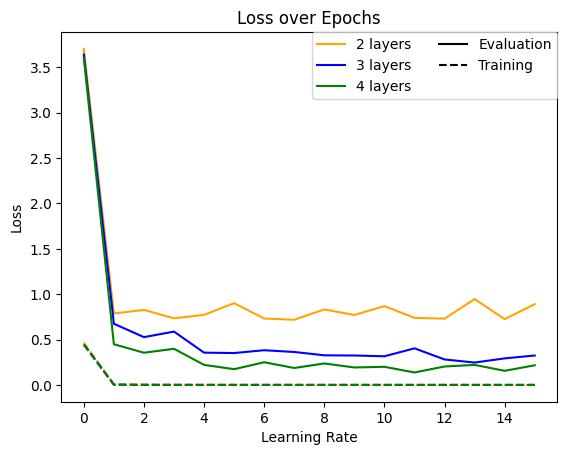

2layers-lr0.007: training loss: 0.0006902410458655467, validation loss: 0.7182055382989347
3layers-lr0.013: training loss: 0.00017649724541348778, validation loss: 0.24667486349935644
4layers-lr0.011: training loss: 0.0002165229257465958, validation loss: 0.13747880447626812


In [ ]:
display(Image(filename=viz_dir + "xp1-2layers-lr"+str(min_lr2)+'.png'))
display(Image(filename=viz_dir + "xp1-3layers-lr"+str(min_lr3)+'.png'))
display(Image(filename=viz_dir + "xp1-4layers-lr"+str(min_lr4)+'.png'))

p1 = plt.plot(train_loss_2l,c='orange', ls='dashed')
p2 = plt.plot(val_loss_2l, c='orange')
p3 = plt.plot(train_loss_3l, c='blue', ls='dashed')
p4 = plt.plot(val_loss_3l, c='blue')
p5 = plt.plot(train_loss_4l, c='green', ls='dashed')
p6 = plt.plot(val_loss_4l, c='green')

plt.xlabel('Learning Rate'), plt.ylabel('Loss')
orange_line = mlines.Line2D([], [], color='orange', label='2 layers')
blue_line = mlines.Line2D([], [], color='blue', label='3 layers')
green_line = mlines.Line2D([], [], color='green', label='4 layers')
plain_line = mlines.Line2D([], [], color='black', label='Evaluation')
doted_line = mlines.Line2D([], [], color='black', label='Training', ls='dashed')
plt.legend(handles = [orange_line, blue_line, green_line, plain_line, doted_line], loc=1, ncol=2, borderaxespad=0.)
plt.title("Loss over Epochs")
plt.savefig(viz_dir + 'xp2.png')
plt.show()


print("2layers-lr"+str(min_lr2)+": training loss: "+str(min_train_2l)+", validation loss: "+ str(min_test_2l))
print("3layers-lr"+str(min_lr3)+": training loss: "+str(min_train_3l)+", validation loss: "+ str(min_test_3l))
print("4layers-lr"+str(min_lr4)+": training loss: "+str(min_train_4l)+", validation loss: "+ str(min_test_4l))

The highest observed accuracy is for the model with 4 convolutional layers, therefore, we will keep this architecture for the following experiments and will use the learning rate that corresponded to the lowest loss, LR = 0.011.

### Experiment 3: Number of channels

In this experiment we want to assess how the number of channels (feature maps) affect the model performanced. We will keep 4 layer model with normalization and attempt different feature map combinations.

In [ ]:
# Parameters
num_layers = 4
input_size_linear = 64
num_channels = [3, 8, 16, 32, 64]
num_epochs = 20
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.011

# Experiment
model_64_opt, train_loss_64, val_loss_64 = experiment(input_size_linear, num_layers, num_channels, num_epochs, loss_fn, learning_rate, "xp3-64", show=False, norm=True)

In [ ]:
# Parameters
num_layers = 4
input_size_linear = 256
num_channels = [3, 32, 64, 128, 256]
num_epochs = 20
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.011

# Experiment
model_256_opt, train_loss_256, val_loss_256 = experiment(input_size_linear, num_layers, num_channels, num_epochs, loss_fn, learning_rate, "xp3-256", show=False, norm=True)

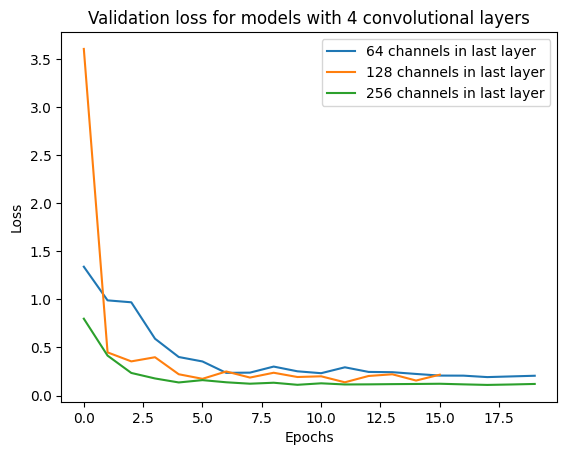

In [ ]:
plt.plot(val_loss_64, label='64 channels in last layer')
plt.plot(val_loss_4l, label='128 channels in last layer')
plt.plot(val_loss_256, label='256 channels in last layer')

plt.xlabel('Epochs'), plt.ylabel('Loss')
plt.legend()
plt.title("Validation loss for models with 4 convolutional layers")

plt.savefig(viz_dir + 'xp3.png')

plt.show()

In [ ]:
print(f"""
Test loss, 64 channels: {eval_cnn_classifier(model_64_opt, test_dataloader, loss_fn)}
Test loss, 128 channels: {eval_cnn_classifier(model_4l_opt, test_dataloader, loss_fn)}
Test loss, 256 channels: {eval_cnn_classifier(model_256_opt, test_dataloader, loss_fn)}
""")


Test loss, 64 channels: 0.2803677452960983
Test loss, 128 channels: 0.2952053139451891
Test loss, 256 channels: 0.2234581612792681



In [ ]:
y_pred_4l, y_true_4l = get_ypred_ytrue(model_4l_opt)
y_pred_64, y_true_64 = get_ypred_ytrue(model_64_opt)
y_pred_256, y_true_256 = get_ypred_ytrue(model_256_opt)


print(f"Accuracy, 64 channels: {accuracy_score(y_pred=y_pred_64, y_true=y_true_64)}")
print(f"Accuracy, 128 channels: {accuracy_score(y_pred=y_pred_4l, y_true=y_true_4l)}")
print(f"Accuracy, 256 channels: {accuracy_score(y_pred=y_pred_256, y_true=y_true_256)}")

Accuracy, 64 channels: 0.9102564102564102
Accuracy, 128 channels: 0.9230769230769231
Accuracy, 256 channels: 0.9423076923076923


We can see that the model with 256 channels performs the best and we'll keep it for further experiments.

### Experiment 4: Kernel size

In this experiment we will test if smaller convolution kernel would result in a better performance. We will compare kernel size = 5 (used in all previous experiments), and kernel size = 3.

In [ ]:
# Parameters
num_layers = 4
input_size_linear = 2304
num_channels = [3, 32, 64, 128, 256]
num_epochs = 40
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.011

# Experiment
model_kernel3_opt, train_loss_kernel3, val_loss_kernel3 = experiment(input_size_linear,
                                                      num_layers,
                                                      num_channels,
                                                      num_epochs,
                                                      loss_fn,
                                                      learning_rate,
                                                      "xp4",
                                                      show=False,
                                                      norm=True,
                                                      conv_kernel=3)

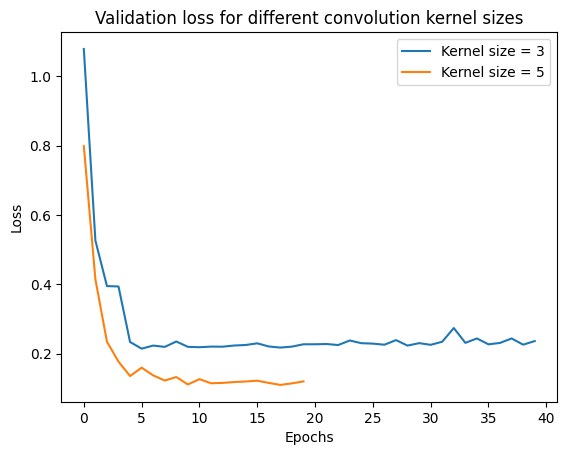

In [ ]:
plt.plot(val_loss_kernel3, label='Kernel size = 3')
plt.plot(val_loss_256, label='Kernel size = 5')

plt.xlabel('Epochs'), plt.ylabel('Loss')
plt.legend()
plt.title("Validation loss for different convolution kernel sizes")
plt.savefig(viz_dir+'xp4.png')
plt.show()

In [ ]:
print(f"""
Test loss, kernel size = 3: {eval_cnn_classifier(model_kernel3_opt, test_dataloader, loss_fn)}
Test loss, kernel size = 5: {eval_cnn_classifier(model_256_opt, test_dataloader, loss_fn)}
""")


Test loss, kernel size = 3: 0.2780271774623543
Test loss, kernel size = 5: 0.22344608257699292



In [ ]:
y_pred_3, y_true_3 = get_ypred_ytrue(model_kernel3_opt)
y_pred_5, y_true_5 = get_ypred_ytrue(model_256_opt)


print(f"Accuracy, kernel size = 3: {accuracy_score(y_pred=y_pred_3, y_true=y_true_3)}")
print(f"Accuracy, kernel size = 5: {accuracy_score(y_pred=y_pred_5, y_true=y_true_5)}")

Accuracy, kernel size = 3: 0.9358974358974359
Accuracy, kernel size = 5: 0.9423076923076923


Smaller kernel appears to perform worse than the kernel of siwe 5, therefore, we won't change it.

### Experiment 5: Activation function

In this section, we will test the effect of activation function in the convolution layers. We will compare ReLU (used in all previous experiments) and Leaky ReLU.

In [ ]:
# Parameters
# Parameters
num_layers = 4
input_size_linear = 256
num_channels = [3, 32, 64, 128, 256]
num_epochs = 20
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.011

# Experiment
model_leaky_opt, train_loss_leaky, val_loss_leaky = experiment(input_size_linear,
                                                         num_layers,
                                                         num_channels,
                                                         num_epochs,
                                                         loss_fn,
                                                         learning_rate,
                                                         "xp5",
                                                         show=False,
                                                         norm=True,
                                                         act_fn=nn.LeakyReLU())

Text(0.5, 1.0, 'Validation loss for different activation functions')

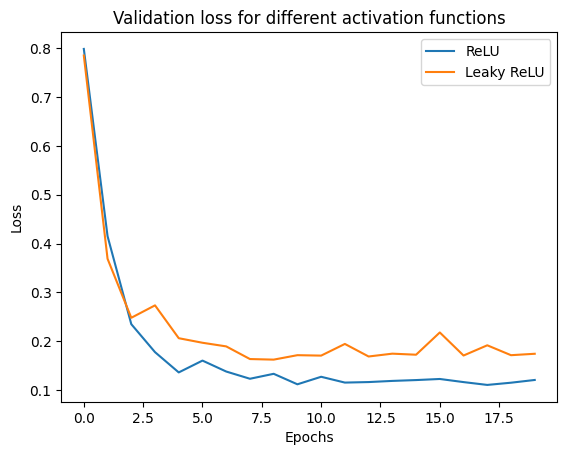

In [ ]:
plt.plot(val_loss_256, label='ReLU')
plt.plot(val_loss_leaky, label='Leaky ReLU')

plt.xlabel('Epochs'), plt.ylabel('Loss')
plt.legend()
plt.title("Validation loss for different activation functions")

In [ ]:
print(f"""
Test loss, ReLU: {eval_cnn_classifier(model_256_opt, test_dataloader, loss_fn)}
Test loss, Leaky ReLU: {eval_cnn_classifier(model_leaky_opt, test_dataloader, loss_fn)}
""")


Test loss, ReLU: 0.24845670687500387
Test loss, Leaky ReLU: 0.17137802216457204



It appears that we can gain performance improvement with Leaky ReLU, therefore, we will use it in our final model.

### Experiment 6: Pooling

In the final experiment, we want to compare max pooling that was used in all previous experiments and average pooling.

In [ ]:
# Parameters
num_layers = 4
input_size_linear = 256
num_channels = [3, 32, 64, 128, 256]
num_epochs = 20
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.011

# Experiment
model_avgpool_opt, train_loss_avgpool, val_loss_avgpool = experiment(input_size_linear,
                                                         num_layers,
                                                         num_channels,
                                                         num_epochs,
                                                         loss_fn,
                                                         learning_rate,
                                                         "xp6",
                                                         show=False,
                                                         norm=True,
                                                        act_fn=nn.LeakyReLU(),
                                                         pooling=nn.AvgPool2d(kernel_size=2))

Text(0.5, 1.0, 'Validation loss for different pooling')

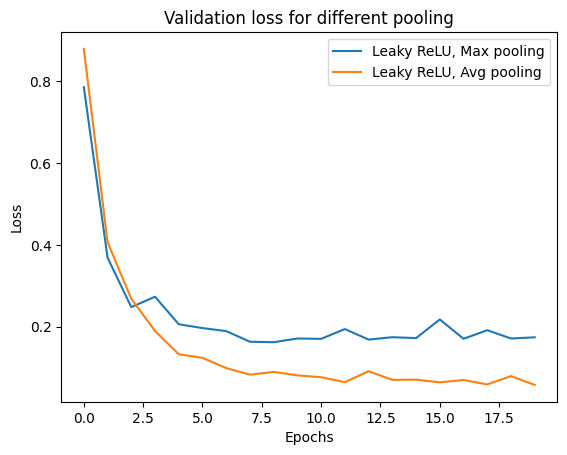

In [ ]:
plt.plot(val_loss_leaky, label='Leaky ReLU, Max pooling')
plt.plot(val_loss_avgpool, label='Leaky ReLU, Avg pooling')


plt.xlabel('Epochs'), plt.ylabel('Loss')
plt.legend()
plt.title("Validation loss for different pooling")

In [ ]:
y_pred_avgpool, y_true_avgpool = get_ypred_ytrue(model_avgpool_opt)


print(f"Accuracy, Leaky ReLU, avg pooling: {accuracy_score(y_pred=y_pred_avgpool, y_true=y_true_avgpool)}")

Accuracy, Leaky ReLU, avg pooling: 0.9807692307692307


We can see that combining the architecture of 4 convolution layers, higher number of feature maps, batch normalization, leaky ReLU and average pooling we can get a very high accuracy on the test set, therefore, we will use it as our final model.

## Final Model

In [ ]:
torch.save(model_avgpool_opt.state_dict(), "best_model.pt")

In [ ]:
model_avgpool_opt

CNNClassif(
  (conv_layers): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(5, 5), stride=

### T-SNE

In addition to evaluating the accuracy on test set, we can also investigate how well the learned representations correspond to each letter of the alphabet.

In [ ]:
# We provide here a function for displaying the t-SNE embeddings
import matplotlib as mpl


color = mpl.colormaps['hsv'].resampled(26)

def plot_tsne_embeddings(X, y, title):

    y = y.astype(int)
    X = QuantileTransformer().fit_transform(X)

    plt.figure(figsize = (6,6))
    for i in range(X.shape[0]):
        plt.text(X[i, 0],
                 X[i, 1],
                 alphabet[int(y[i])],
                 color=color(y[i]),
                 fontdict={"weight": "bold", "size": 9})
    plt.xticks([]), plt.yticks([])
    plt.title('t-SNE - ' + title, fontsize=16)
    plt.show()

    return

In [ ]:
# Parameters
num_layers = 4
input_size_linear = 256
num_channels = [3, 32, 64, 128, 256]
norm = True
num_classes = 26
weights_file_path = "/content/drive/MyDrive/nn_project/best_model (1).pt"

Size of vectorized feature maps: (160, 256)
Size of the tensor storing labels: (160,)
Size TSNE embeddings (input images): (160, 2)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (160). n_quantiles is set to n_samples.
  warnings.warn(


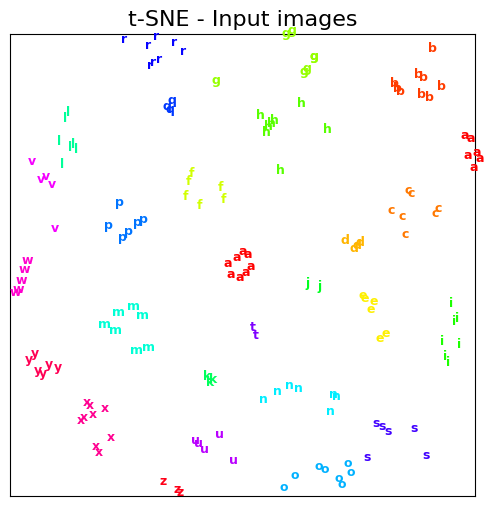

In [ ]:
model = CNNClassif(input_size_linear, num_layers, num_channels, num_classes,
                        conv_kernel=5, padding=2,
                       act_fn=nn.LeakyReLU(), norm=True,
                 pooling=nn.AvgPool2d(kernel_size=2))

model.load_state_dict(torch.load(weights_file_path))

model.eval()

# First, let us collect all the vectorized input images into one tensor (same for labels)
# Then, we convert these back to numpy

len_dataset = len(test_dataloader) * batch_size

feature_maps_tot = torch.empty((len_dataset, input_size_linear), dtype=torch.float)
labels_im_tot = torch.empty(len_dataset, dtype=torch.float)

model.eval()
with torch.no_grad():
    for ib, (images, labels) in enumerate(test_dataloader):
        if len(images) == batch_size:
            indices_b = torch.arange(ib*batch_size, (ib+1)*batch_size)
            labels_im_tot[indices_b] = labels.float()
            for i in range(num_layers):
                images = model.conv_layers[i](images)
            in_im_vec = images.reshape(batch_size, -1)
            feature_maps_tot[indices_b, :] = in_im_vec

feature_maps_tot = feature_maps_tot.numpy()
labels_im_tot = labels_im_tot.numpy()
print('Size of vectorized feature maps:', feature_maps_tot.shape)
print('Size of the tensor storing labels:', labels_im_tot.shape)

# Compute t-SNE embeddings from the input images
images_TSNE = TSNE(n_components=2, init='pca').fit_transform(feature_maps_tot)
print('Size TSNE embeddings (input images):', images_TSNE.shape)

# Apply this function to the input images after TSNE
plot_tsne_embeddings(images_TSNE, labels_im_tot, 'Input images')


We can see that the learned representations group characters pretty well with no overlap, therefore, we can conclude that our classifier is managed to learn very robust and high aquality representations.